In [1]:
## import libraries for data preparation 
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time
import matplotlib.pyplot as plt

In [2]:
files = ['./exercise_02_train.csv']
df = pd.read_csv('./eercise_02_train.csv')

In [3]:
## examine file info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 101 entries, x0 to y
dtypes: float64(94), int64(1), object(6)
memory usage: 30.8+ MB


In [4]:
## check missing values
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns, 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df.tail()

,column_name,percent_missing
x85,x85,0.0350
x18,x18,0.0350
x13,x13,0.0350
x63,x63,0.0350
x96,x96,0.0375


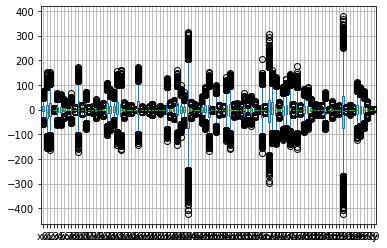

In [5]:
## visusalize data 
%matplotlib inline
df.boxplot()

## the result shows the data is imbalanced

In [6]:
## check the distribution of predicted variable, turns out we have imbalanced y as well, but no missing value

df.y.value_counts()

0    31856
1     8144
Name: y, dtype: int64

In [7]:
## transform categorical features
df_object = df.select_dtypes(include=['object'])
df_object.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 6 columns):
x34    39993 non-null object
x35    39987 non-null object
x41    39996 non-null object
x45    39995 non-null object
x68    39992 non-null object
x93    39993 non-null object
dtypes: object(6)
memory usage: 1.8+ MB


In [8]:
df_object.describe()

,x34,x35,x41,x45,x68,x93
count,39993,39987,39996,39995,39992,39993
unique,10,8,37863,10,12,3
top,volkswagon,wed,$-1073.04,-0.01%,July,asia
freq,12455,14793,4,9578,11080,35416


In [9]:
df.x35.value_counts()

wed          14793
thurday      13375
wednesday     5920
thur          4383
tuesday        894
friday         537
monday          61
fri             24
Name: x35, dtype: int64

In [10]:
def weekday(X):
    if X == 'wed':
        return 'wednesday'
    elif X == 'thur':
        return 'thursday'
    elif X == 'thurday':
        return 'thursday'
    elif X == 'fri':
        return 'friday'
    else:
        return X

In [11]:
df.x35 = df.x35.apply(weekday)
df.x41 = df_object.x41.map(lambda x: x if type(x) == float else float(x.strip('$')))
df.x45 = df_object.x45.map(lambda x: x if type(x) == float else float(x.strip('%')))

In [12]:
## split training and test dataset

y = df.y
X = df.drop(columns = ['y'])
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state= 50)

In [13]:
## fill missing values with mode for categorical variables
for column in ['x34', 'x35', 'x68', 'x93']:
    X_train[column].fillna(X_train[column].mode()[0], inplace=True)
    X_test[column].fillna(X_train[column].mode()[0], inplace=True)

C:\Users\lv_hua\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [14]:
## fill missing values for all numerical variables

for col in X_train.select_dtypes(include=np.number):
    X_train[col] = X_train[col].fillna(X_train[col].mean())

for col in X_test.select_dtypes(include=np.number):
    X_test[col] = X_test[col].fillna(X_train[col].mean())

C:\Users\lv_hua\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\lv_hua\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [15]:
## Label encoding on categorical features using one hot encoding. Sparsity is better for later feature engineering

X_train= pd.get_dummies(X_train, columns=['x34', 'x35', 'x68', 'x93'])
X_test = pd.get_dummies(X_test, columns=['x34', 'x35', 'x68', 'x93'])

In [16]:
## Normalize data for following analysis

X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)

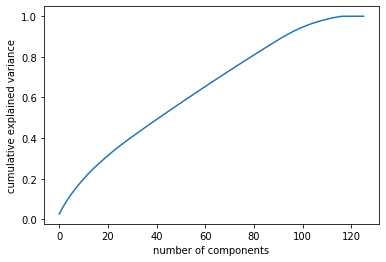

In [17]:
## Dimensionality reduction using PCA
X_train_pca = PCA().fit_transform (X_train_scaled)

## visualizae PCA to examine principal components
%matplotlib inline
pca = PCA().fit(X_train_scaled)

plt.figure()
var_exp=pca.explained_variance_ratio_ 
cum_var_exp=np.cumsum(var_exp)
plt.plot(cum_var_exp)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()


In [18]:
## Since PCA does not significantly reduce dimensionality, random forest is tested for possible feature selection 

## random forest classifier does not necessarily require normalize data but I used normalized data for more accuracy

## since we have imbalanced data, we want to use the parameter to deal with the problem

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(class_weight = "balanced")
model.fit(X_train_scaled, y_train)

C:\Users\lv_hua\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [19]:
feature_names = list(X_train.columns)
features = sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), feature_names), 
             reverse=True)
print(features)

[(0.0418, 'x75'), (0.0376, 'x37'), (0.0354, 'x97'), (0.029, 'x58'), (0.0255, 'x41'), (0.0196, 'x99'), (0.0188, 'x51'), (0.0179, 'x1'), (0.0178, 'x44'), (0.0166, 'x96'), (0.0166, 'x21'), (0.0165, 'x56'), (0.0164, 'x72'), (0.0157, 'x66'), (0.0157, 'x63'), (0.0157, 'x10'), (0.0153, 'x50'), (0.0152, 'x5'), (0.0149, 'x70'), (0.0144, 'x40'), (0.0144, 'x22'), (0.0143, 'x53'), (0.0135, 'x83'), (0.0134, 'x78'), (0.0133, 'x69'), (0.0126, 'x79'), (0.0124, 'x85'), (0.0123, 'x57'), (0.0123, 'x33'), (0.012, 'x4'), (0.012, 'x3'), (0.0119, 'x43'), (0.0118, 'x73'), (0.0114, 'x27'), (0.0111, 'x74'), (0.011, 'x95'), (0.0109, 'x0'), (0.0108, 'x2'), (0.0108, 'x19'), (0.0105, 'x8'), (0.0105, 'x20'), (0.0102, 'x25'), (0.01, 'x12'), (0.0098, 'x49'), (0.0096, 'x77'), (0.0095, 'x47'), (0.0093, 'x42'), (0.0091, 'x71'), (0.0086, 'x90'), (0.0085, 'x61'), (0.0076, 'x18'), (0.0072, 'x80'), (0.006, 'x11'), (0.0058, 'x46'), (0.0058, 'x13'), (0.0056, 'x81'), (0.0055, 'x29'), (0.0054, 'x45'), (0.0053, 'x9'), (0.0053, 'x

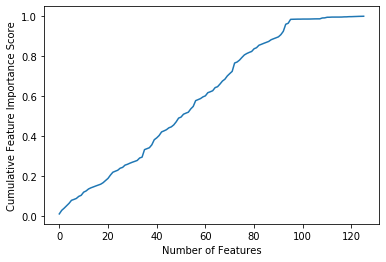

In [20]:
## visualize feature importance

%matplotlib inline
# Creating a line plot

plt.figure()
cum_fimps=np.cumsum(model.feature_importances_)
plt.plot(cum_fimps)
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Feature Importance Score')
plt.show()

In [21]:
## at this point, with no additional background information about the data or specific business questions
## feature enginerring does not provide any insights into the model building or problem solving
## I decided to do a quick classification ##model comparison to see which one perform the best with the prediction 

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

In [22]:
## create a dictionary to store all the models

dict_classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Nearest Neighbors": KNeighborsClassifier(),
    "Linear SVM": SVC(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(n_estimators=1000),
    "Decision Tree": tree.DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=1000),
    "Neural Net": MLPClassifier(alpha = 1),
    "Naive Bayes": GaussianNB(),
    "XGBoost Classifier": XGBClassifier()
}


In [23]:
## import metrics to evaluate models

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

In [24]:
## create a function to test and compare different classification models based on accurarcy, ROC, precision, 
## recall and training time

def batch_classify(X_train, y_train, X_test, y_test, no_classifiers = 9, verbose = True):
     
    dict_models = {}
    for classifier_name, classifier in list(dict_classifiers.items())[:no_classifiers]:
        t_start = time.clock()
        classifier.fit(X_train_scaled, y_train)
        t_end = time.clock()
        
        t_diff = t_end - t_start
        y_train_pred = classifier.predict(X_train_scaled) 
        y_test_pred = classifier.predict(X_test_scaled)
        
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        train_precision = precision_score(y_train, y_train_pred)
        test_precision = precision_score(y_test, y_test_pred)
        train_recall = recall_score(y_train, y_train_pred)
        test_recall = recall_score(y_test, y_test_pred)
        train_roc = roc_auc_score(y_train, y_train_pred)
        test_roc = roc_auc_score(y_test, y_test_pred)
        
        dict_models[classifier_name] = {'model': classifier, 'train_accuracy': train_accuracy, 'test_accuracy': test_accuracy, 
                                        'train_precision': train_precision, 'test_precision': test_precision, 
                                        'train_recall': train_recall, 'test_recall': test_recall, 'train_roc': train_roc, 
                                        'test_roc': test_roc, 'train_time': t_diff}
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=classifier_name, f=t_diff))
    return dict_models
 
 
 
def display_dict_models(dict_models, sort_by='test_accuracy'):
    cls = [key for key in dict_models.keys()]
    test_a = [dict_models[key]['test_accuracy'] for key in cls]
    training_a = [dict_models[key]['train_accuracy'] for key in cls]
    test_p = [dict_models[key]['test_precision'] for key in cls]
    training_p = [dict_models[key]['train_precision'] for key in cls]
    test_r = [dict_models[key]['test_recall'] for key in cls]
    training_r = [dict_models[key]['train_recall'] for key in cls]
    test_roc = [dict_models[key]['test_roc'] for key in cls]
    training_roc = [dict_models[key]['train_roc'] for key in cls]
    training_t = [dict_models[key]['train_time'] for key in cls]
    
    
    df_ = pd.DataFrame(data=np.zeros(shape=(len(cls),10)), columns = ['classifier', 'train_accuracy', 'test_accuracy',
                                                                      'train_precision', 'test_precision', 'train_recall',
                                                                      'test_recall', 'train_roc', 'test_roc', 'train_time'])
    for ii in range(0,len(cls)):
        df_.loc[ii, 'classifier'] = cls[ii]
        df_.loc[ii, 'train_accuracy'] = training_a[ii]
        df_.loc[ii, 'test_accuracy'] = test_a[ii]
        df_.loc[ii, 'test_precision'] = test_p[ii]
        df_.loc[ii, 'train_precision'] = training_p[ii]
        df_.loc[ii, 'test_recall'] = test_r[ii]
        df_.loc[ii, 'train_recall'] = training_r[ii] 
        df_.loc[ii, 'test_roc'] = test_roc[ii]
        df_.loc[ii, 'train_roc'] = training_roc[ii]
        df_.loc[ii, 'train_time'] = training_t[ii]
    
    display(df_.sort_values(by=sort_by, ascending=False))

In [25]:
dict_models = batch_classify(X_train_scaled, y_train, X_test_scaled, y_test, no_classifiers = 9)
display_dict_models(dict_models)

C:\Users\lv_hua\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
C:\Users\lv_hua\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\lv_hua\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.
C:\Users\lv_hua\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or

trained Logistic Regression in 1.14 s


C:\Users\lv_hua\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.


trained Nearest Neighbors in 1.78 s


C:\Users\lv_hua\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
C:\Users\lv_hua\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.


trained Linear SVM in 128.39 s


C:\Users\lv_hua\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
C:\Users\lv_hua\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.


trained Gradient Boosting Classifier in 210.34 s


C:\Users\lv_hua\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
C:\Users\lv_hua\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.
C:\Users\lv_hua\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


trained Decision Tree in 4.69 s


C:\Users\lv_hua\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.


trained Random Forest in 219.31 s


C:\Users\lv_hua\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
C:\Users\lv_hua\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.
C:\Users\lv_hua\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
C:\Users\lv_hua\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use t

trained Neural Net in 7.60 s
trained Naive Bayes in 0.08 s


C:\Users\lv_hua\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
C:\Users\lv_hua\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.


trained XGBoost Classifier in 21.40 s


,classifier,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_roc,test_roc,train_time
2,Linear SVM,0.993594,0.985375,0.995288,0.989657,0.973127,0.938113,0.985975,0.967800,128.394758
6,Neural Net,0.990219,0.984500,0.992062,0.983954,0.959613,0.939338,0.978826,0.967706,7.603836
3,Gradient Boosting Classifier,0.989750,0.953875,0.991418,0.938237,0.957924,0.828431,0.977903,0.907228,210.339529
8,XGBoost Classifier,0.915250,0.907125,0.953461,0.940535,0.613483,0.581495,0.802916,0.786036,21.399049
1,Nearest Neighbors,0.942094,0.906875,0.982998,0.943944,0.728041,0.577819,0.862412,0.784512,1.776531
0,Logistic Regression,0.891375,0.893000,0.802752,0.810897,0.618090,0.620098,0.789644,0.791519,1.137220
5,Random Forest,1.000000,0.877875,1.000000,0.995461,1.000000,0.403186,1.000000,0.701358,219.308367
4,Decision Tree,1.000000,0.824500,1.000000,0.566745,1.000000,0.593137,1.000000,0.738466,4.686482
7,Naive Bayes,0.793375,0.787625,0.483005,0.455746,0.218213,0.211397,0.579269,0.573349,0.080993


In [26]:
## With no business information is available, model performance is the top priority in model selection.
## Therefore, the top two models are selected for the this analysis. 

#Model 1 SVM
# The Gaussian RBF kernel is very popular and makes a good default kernel especially in absence of expert knowledge 
# about data and domain because it kind of subsumes polynomial and linear kernel as well. Linear Kernels and Polynomial Kernels
# are a special case of Gaussian RBF kernel. Gaussian RBF kernels are non-parametric model which essentially means that the 
# complexity of the model is potentially infinite because the number of analytic functions are infinite.

from sklearn.svm import SVC
svclassifier = SVC(probability=True)
svclassifier.fit(X_train_scaled, y_train)
y_svm_pred = svclassifier.predict(X_test_scaled)

In [27]:
# evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_svm_pred))
print(classification_report(y_test,y_svm_pred))


[[6352   16]
 [ 101 1531]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6368
           1       0.99      0.94      0.96      1632

    accuracy                           0.99      8000
   macro avg       0.99      0.97      0.98      8000
weighted avg       0.99      0.99      0.99      8000



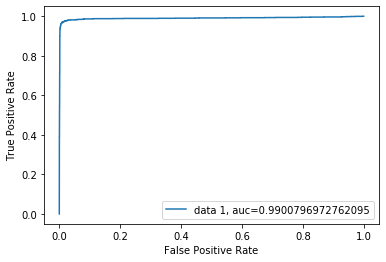

In [28]:
# plot ROC AUC with SVM

import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

y_svm_pred_proba = svclassifier.predict_proba(X_test_scaled)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_svm_pred_proba)
auc = metrics.roc_auc_score(y_test, y_svm_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

In [29]:
#model 2 ANN
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(X_train_scaled, y_train)
y_mlp_pred = mlp.predict(X_test_scaled)

In [30]:
# evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_mlp_pred))
print(classification_report(y_test,y_mlp_pred))

[[6319   49]
 [  68 1564]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6368
           1       0.97      0.96      0.96      1632

    accuracy                           0.99      8000
   macro avg       0.98      0.98      0.98      8000
weighted avg       0.99      0.99      0.99      8000



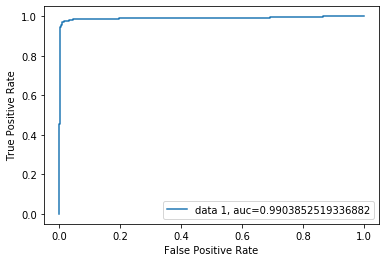

In [31]:
# plot ROC AUC with ANN

import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

y_mlp_pred_proba = mlp.predict_proba(X_test_scaled)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_mlp_pred_proba)
auc = metrics.roc_auc_score(y_test, y_mlp_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()